# DQN and GAE framework for RL agent 

# Environment 

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch

class Environment:
    def __init__(self, xmin=0, xmax=100, ymin=0, ymax=100, num_rectangles=5, num_circles=5, min_distance=50):
        self.xlim = (xmin, xmax)
        self.ylim = (ymin, ymax)
        self.num_rectangles = num_rectangles
        self.num_circles = num_circles
        self.min_distance = min_distance
        self.random_obstacles()
        self.x_start, self.y_start = self.random_start()
        self.x_goal, self.y_goal = self.random_goal()

    def random_obstacles(self):
        # Generate random rectangles
        self.obst_x, self.obst_y = [], []
        for _ in range(self.num_rectangles):
            x1, y1 = np.random.uniform(self.xlim[0], self.xlim[1]), np.random.uniform(self.ylim[0], self.ylim[1])
            x2, y2 = x1 + np.random.uniform(5, 15), y1 + np.random.uniform(5, 15)
            self.obst_x.extend([x1, x1, x2, x2])
            self.obst_y.extend([y1, y2, y2, y1])

        # Generate random circles
        self.radii = [np.random.uniform(2, 7) for _ in range(self.num_circles)]
        self.circle_x = [np.random.uniform(self.xlim[0], self.xlim[1]) for _ in range(self.num_circles)]
        self.circle_y = [np.random.uniform(self.ylim[0], self.ylim[1]) for _ in range(self.num_circles)]

    def random_start(self):
        while True:
            x_start, y_start = np.random.uniform(self.xlim[0], self.xlim[1]), np.random.uniform(self.ylim[0], self.ylim[1])
            if not self.is_inside_obstacle(x_start, y_start, 0):  # Pass 0 as robot radius for initial placement
                return x_start, y_start

    def random_goal(self):
        while True:
            x_goal, y_goal = np.random.uniform(self.xlim[0], self.xlim[1]), np.random.uniform(self.ylim[0], self.ylim[1])
            if not self.is_inside_obstacle(x_goal, y_goal, 0):  # Pass 0 as robot radius for initial placement
                dist = np.sqrt((x_goal - self.x_start)**2 + (y_goal - self.y_start)**2)
                if dist >= self.min_distance:
                    return x_goal, y_goal

    def is_inside_obstacle(self, x, y, rbot):
        # Check rectangular obstacles
        for i in range(self.num_rectangles):
            rect_x = self.obst_x[4 * i:4 * (i + 1)]
            rect_y = self.obst_y[4 * i:4 * (i + 1)]
            if (min(rect_x) - rbot) <= x <= (max(rect_x) + rbot) and \
               (min(rect_y) - rbot) <= y <= (max(rect_y) + rbot):
                return True

        # Check circular obstacles
        for i in range(self.num_circles):
            if (x - self.circle_x[i])**2 + (y - self.circle_y[i])**2 <= (self.radii[i] + rbot)**2:
                return True

        return False

    def plot_obstacles(self, rbot):
        plt.plot([0 - 2*rbot, 0 - 2*rbot, 100 + 2*rbot, 100 + 2*rbot, 0 - 2*rbot],
                 [0 - 2*rbot, 100 + 2*rbot, 100 + 2*rbot, 0 - 2*rbot, 0 - 2*rbot], 'k', lw=0.5)
        plt.plot(self.x_goal, self.y_goal, 'g*', markersize=20)
        plt.plot(self.x_start, self.y_start, 'b*', markersize=20)

        # Plot rectangles
        for i in range(self.num_rectangles):
            x = self.obst_x[4 * i]
            y = self.obst_y[4 * i]
            width = self.obst_x[4 * i + 2] - self.obst_x[4 * i]
            height = self.obst_y[4 * i + 2] - self.obst_y[4 * i]
            rect = plt.Rectangle((x, y), width, height, linewidth=1, color='r')
            plt.gca().add_patch(rect)

        # Plot circles
        for i in range(self.num_circles):
            circle = plt.Circle((self.circle_x[i], self.circle_y[i]), self.radii[i], color='r')
            plt.gca().add_patch(circle)

        plt.gca().set_aspect('equal', adjustable='box')

    


    # plotting Functions    
    def save_frame(self, directory, frame_count):
        if not os.path.exists(directory):
            os.makedirs(directory)
        frame_path = os.path.join(directory, f"frame_{frame_count:04d}.png")
        plt.savefig(frame_path)
        print(f"Frame saved: {frame_path}")
        plt.close()


    def draw(self, robot, tree=None, path=None, save_frames=False, frame_dir="rlframes", frame_count=0):
        self.plot_obstacles(robot.rbot)
        
        # Plot robot position
        plt.plot(robot.pos[0], robot.pos[1], 'ko', markersize=10)
        
        # Plotting the RRT tree (lines only)
        if tree:
            for parent, child in tree.graph.edges():
                plt.plot([parent.coordinates[0], child.coordinates[0]], 
                        [parent.coordinates[1], child.coordinates[1]], 'b-', lw=1)

        # Plotting the path to the goal (nodes and lines)
        if path:
            for i in range(len(path) - 1):
                plt.plot([path[i][0], path[i+1][0]], 
                        [path[i][1], path[i+1][1]], 'g-', lw=2)
            for node in path:
                plt.plot(node[0], node[1], 'go', markersize=5)

        if save_frames:
            self.save_frame(frame_dir, frame_count)
        else:
            plt.show()


In [4]:
import numpy as np
import torch

class Robot:
    def __init__(self, env, rbot=3, max_dist=5):
        self.env = env
        self.rbot = rbot
        self.max_dist = max_dist
        self.pos = [env.x_start, env.y_start]
        
    def move(self, action):
        new_pos = self.pos.copy()
        if action == 0:
            new_pos[0] += self.max_dist
        elif action == 1:
            new_pos[0] -= self.max_dist
        elif action == 2:
            new_pos[1] += self.max_dist
        elif action == 3:
            new_pos[1] -= self.max_dist
            
        if not self.env.is_inside_obstacle(new_pos[0], new_pos[1], self.rbot):
            self.pos = new_pos
            
        return self.pos

    def sample_grid(self, grid_size=5):
        x_range = np.arange(self.env.xlim[0], self.env.xlim[1], grid_size)
        y_range = np.arange(self.env.ylim[0], self.env.ylim[1], grid_size)
        features = []
        edge_index = []

        # Create feature matrix and adjacency matrix
        node_index = 0
        for i in x_range:
            for j in y_range:
                features.append([i, j, self.pos[0], self.pos[1]])
                # Connect to neighboring nodes (4-neighborhood)
                if i + grid_size < self.env.xlim[1]:
                    edge_index.append([node_index, node_index + len(y_range)])
                    edge_index.append([node_index + len(y_range), node_index])
                if j + grid_size < self.env.ylim[1]:
                    edge_index.append([node_index, node_index + 1])
                    edge_index.append([node_index + 1, node_index])
                node_index += 1

        features = torch.tensor(features, dtype=torch.float)
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

        return features, edge_index

    def get_reward(self, action):
        new_pos = self.move(action)
        x, y = new_pos

        if self.env.is_inside_obstacle(x, y, self.rbot):
            return -100  # Hitting an obstacle

        if [x, y] == [self.env.x_goal, self.env.y_goal]:
            return 1000  # Reaching the goal

        return -1  # Step penalty

    def step(self, action):
        reward = self.get_reward(action)
        new_state = self.sample_grid()
        goal_check = self.pos == [self.env.x_goal, self.env.y_goal] or reward == -100
        return new_state, reward, goal_check

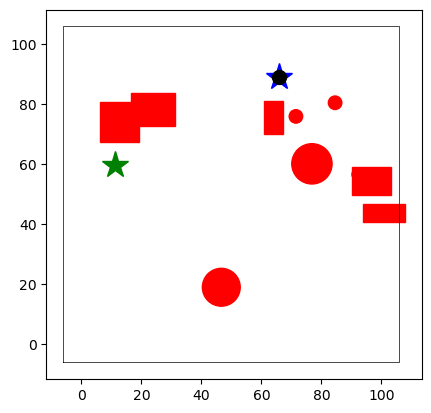

In [5]:
# Checking the Environment and Robot Class
env = Environment()
robot = Robot(env)
env.draw(robot)

# GAE

In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.utils import to_dense_adj, dense_to_sparse
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv

In [7]:
class GAE(torch.nn.Module):
    """Graph Auto-Encoder for environment representation"""
    def __init__(self):
        super(GAE, self).__init__()
        # Input: [num_nodes, 4] -> Hidden: [num_nodes, 8] -> Output: [num_nodes, 2]
        self.encoder = torch.nn.ModuleList([
            GATConv(in_channels=4, out_channels=8, heads=1),
            GATConv(in_channels=8, out_channels=2, heads=1)
        ])
        
    def forward(self, node_features, edge_index):
        """
        Args:
            node_features: [num_nodes, 4] - (x, y, robot_x, robot_y)
            edge_index: [2, num_edges] - Graph connectivity
        Returns:
            embeddings: [num_nodes, 2] - Learned node representations
        """
        x = node_features
        for layer in self.encoder:
            x = F.dropout(x, p=0.6, training=self.training)
            x = layer(x, edge_index)
            x = F.elu(x)
        return x

Training 

In [8]:
def train_gae(epochs, robot_instance, model, optimizer, criterion, grid_size=5):
    best_loss = float('inf')
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        # Get current state representation
        node_features, edge_index = robot_instance.sample_grid(grid_size)
        
        # Forward pass
        embeddings = model(node_features, edge_index)
        
        # Create target adjacency matrix
        edge_index_dense = to_dense_adj(edge_index)[0]
        
        # Reconstruct adjacency from embeddings
        pred_adj = torch.sigmoid(torch.mm(embeddings, embeddings.t()))
        
        # Calculate loss
        loss = F.binary_cross_entropy(pred_adj, edge_index_dense)
        
        # Backprop
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1:03d}, Loss: {loss.item():.4f}')
            
        if loss.item() < best_loss:
            best_loss = loss.item()
            torch.save(model.state_dict(), 'best_gae_model.pt')


In [9]:
def get_embeddings(gae_model, features, edge_index):
    # Set the model to evaluation mode
    gae_model.eval()

    # Generate embeddings using the GAE model
    with torch.no_grad():
        embeddings = gae_model(features, edge_index)
    
    return embeddings

In [10]:

# Usage
gaemodel = GAE()
optimizer = torch.optim.Adam(gaemodel.parameters(), lr=0.001)
criterion = torch.nn.BCELoss()
train_gae(epochs=3000, robot_instance=robot, model=gaemodel, optimizer=optimizer, criterion=criterion)

Epoch 010, Loss: 63.5409
Epoch 020, Loss: 52.5546
Epoch 030, Loss: 42.3869
Epoch 040, Loss: 42.2599
Epoch 050, Loss: 44.7826
Epoch 060, Loss: 43.2719
Epoch 070, Loss: 42.2002
Epoch 080, Loss: 37.3363
Epoch 090, Loss: 30.2441
Epoch 100, Loss: 31.9692
Epoch 110, Loss: 41.4455
Epoch 120, Loss: 34.3776
Epoch 130, Loss: 33.8375
Epoch 140, Loss: 25.4897
Epoch 150, Loss: 22.5895
Epoch 160, Loss: 17.5182
Epoch 170, Loss: 15.1263
Epoch 180, Loss: 26.2762
Epoch 190, Loss: 9.7599
Epoch 200, Loss: 14.4007
Epoch 210, Loss: 12.7147
Epoch 220, Loss: 18.2856
Epoch 230, Loss: 19.3066
Epoch 240, Loss: 14.8698
Epoch 250, Loss: 13.8030
Epoch 260, Loss: 11.5110
Epoch 270, Loss: 12.1151
Epoch 280, Loss: 9.4360
Epoch 290, Loss: 15.8801
Epoch 300, Loss: 15.1183
Epoch 310, Loss: 9.9048
Epoch 320, Loss: 12.9945
Epoch 330, Loss: 10.3355
Epoch 340, Loss: 13.9573
Epoch 350, Loss: 11.5412
Epoch 360, Loss: 8.8476
Epoch 370, Loss: 5.4462
Epoch 380, Loss: 7.0063
Epoch 390, Loss: 8.2255
Epoch 400, Loss: 12.7504
Epoch 4

# DQN

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque
import random


In [12]:
class ReplayBuffer:
    def __init__(self, capacity, device):
        self.buffer = deque(maxlen=capacity)
        self.device = device
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        samples = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*samples)
        return (torch.cat(states).to(self.device), 
                torch.tensor(actions).to(self.device), 
                torch.tensor(rewards).to(self.device),
                torch.cat(next_states).to(self.device), 
                torch.tensor(dones).to(self.device))

    def __len__(self):
        return len(self.buffer)


Training 

In [13]:
class DQN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, output_dim=4):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        return self.network(x)
    
    def predict(self, state):
        with torch.no_grad():
            return self.forward(state).max(1)[1].item()


In [14]:
class DQN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, output_dim=4):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        return self.network(x)
    
    def predict(self, state):
        with torch.no_grad():
            return self.forward(state).max(1)[1].item()


In [15]:
class DQN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, output_dim=4):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        return self.network(x)
    
    def predict(self, state):
        with torch.no_grad():
            return self.forward(state).max(1)[1].item()


In [16]:
def train_dqn(gae_model, num_episodes=1000, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Move models to device
    gae_model = gae_model.to(device)
    dqn = DQN().to(device)
    target_dqn = DQN().to(device)
    target_dqn.load_state_dict(dqn.state_dict())
    
    optimizer = optim.Adam(dqn.parameters())
    memory = ReplayBuffer(10000, device)
    
    epsilon = 1.0
    epsilon_min = 0.01
    epsilon_decay = 0.995
    gamma = 0.99
    
    episode = 0
    while episode < num_episodes:
        env = Environment()
        robot = Robot(env)
        state = robot.sample_grid()
        
        with torch.no_grad():
            state_embedding = gae_model(state[0].to(device), state[1].to(device))
            state_embedding = state_embedding.mean(dim=0).unsqueeze(0)
        
        done = False
        total_reward = 0
        
        while not done:
            if random.random() < epsilon:
                action = random.randint(0, 3)
            else:
                action = dqn.predict(state_embedding)
            
            robot.move(action)
            reward = robot.get_reward(action)
            next_state = robot.sample_grid()
            
            with torch.no_grad():
                next_state_embedding = gae_model(next_state[0].to(device), next_state[1].to(device))
                next_state_embedding = next_state_embedding.mean(dim=0).unsqueeze(0)
            
            done = reward in [-100, 1000]
            
            memory.push(state_embedding, action, reward, next_state_embedding, done)
            
            if len(memory) > batch_size:
                states, actions, rewards, next_states, dones = memory.sample(batch_size)
                
                current_q = dqn(states).gather(1, actions.unsqueeze(1))
                next_q = target_dqn(next_states).max(1)[0].detach()
                target_q = rewards + gamma * next_q * (1 - dones.float())
                
                loss = nn.MSELoss()(current_q.squeeze(), target_q)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                print(f"Episode {episode}, Step Loss: {loss.item()}")
            
            state_embedding = next_state_embedding
            total_reward += reward
            
        if episode % 10 == 0:
            target_dqn.load_state_dict(dqn.state_dict())
        
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}")
        
        episode += 1
    
    return dqn


In [17]:
# Call the train_dqn function with the gaemodel
dqn_model = train_dqn(gae_model=gaemodel, num_episodes=1000, batch_size=32)

Episode 0, Step Loss: 0.6895928382873535
Episode 0, Step Loss: 0.6598098278045654
Episode 0, Step Loss: 0.624643087387085
Episode 0, Step Loss: 0.6139389276504517
Episode 0, Step Loss: 0.5982983112335205
Episode 0, Step Loss: 0.5634328722953796
Episode 0, Step Loss: 0.5255821943283081
Episode 0, Step Loss: 0.5227972865104675
Episode 0, Step Loss: 0.4865626096725464
Episode 0, Step Loss: 0.49052008986473083
Episode 0, Step Loss: 0.46214985847473145
Episode 0, Step Loss: 0.43864721059799194
Episode 0, Step Loss: 0.4327430725097656
Episode 0, Step Loss: 0.38248705863952637
Episode 0, Step Loss: 0.36897361278533936
Episode 0, Step Loss: 0.3526011109352112
Episode 0, Step Loss: 0.31604665517807007
Episode 0, Step Loss: 0.3061288595199585
Episode 0, Step Loss: 0.308959424495697
Episode 0, Step Loss: 0.28726232051849365
Episode 0, Step Loss: 0.24811777472496033
Episode 0, Step Loss: 0.24409009516239166
Episode 0, Step Loss: 0.2211134433746338
Episode 0, Step Loss: 0.20162831246852875
Episode 

KeyboardInterrupt: 